```
This notebook sets up and runs a test case for analyzing Kelvin waves
Copyright (C) 2018 - 2022 SINTEF Digital
Copyright (C) 2018 - 2022 Norwegian Meteorological Institute

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
import sys
gpuocean_path = [p[:-4] for p in sys.path if (p.endswith("gpuocean/src") or p.endswith("gpuocean\\src"))][0]
import git
repo = git.Repo(gpuocean_path)
print("GPUOcean code from:", repo.head.object.hexsha, "on branch", repo.active_branch.name)

GPUOcean code from: a59db749692b363ce71ea29feb9a51d7969ad473 on branch reduced_gravity


# Oslofjord
Testing of Nils projected files

In [2]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime, copy
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt

# plt.rcParams["lines.color"] = "w"
# plt.rcParams["text.color"] = "w"
# plt.rcParams["axes.labelcolor"] = "w"
# plt.rcParams["xtick.color"] = "w"
# plt.rcParams["ytick.color"] = "w"

# plt.rcParams["image.origin"] = "lower"

In [3]:
from gpuocean.utils import IPythonMagic, NetCDFInitialization

In [4]:
%cuda_context_handler barotropic_gpu_ctx

In [5]:
%cuda_context_handler baroclinic_gpu_ctx

Path to the test file

In [6]:
source_url = "/sintef/data/NorFjords160/A03/norfjords_160m_his.nc4_2019110101-2019110200"

## Inspecting file structure and content

In [7]:
import xarray as xr
ds = xr.open_dataset(source_url)
ds

<xarray.Dataset>
Dimensions:      (ocean_time: 24, s_rho: 35, s_w: 36, eta_rho: 801, xi_rho: 1161, eta_u: 801, xi_u: 1160, eta_v: 800, xi_v: 1161)
Coordinates:
  * ocean_time   (ocean_time) datetime64[ns] 2019-11-01T01:00:00 ... 2019-11-02
  * s_rho        (s_rho) float64 -0.9857 -0.9571 -0.9286 ... -0.04286 -0.01429
  * s_w          (s_w) float64 -1.0 -0.9714 -0.9429 ... -0.05714 -0.02857 0.0
    lon_rho      (eta_rho, xi_rho) float64 ...
    lat_rho      (eta_rho, xi_rho) float64 ...
    lon_u        (eta_u, xi_u) float64 ...
    lat_u        (eta_u, xi_u) float64 ...
    lon_v        (eta_v, xi_v) float64 ...
    lat_v        (eta_v, xi_v) float64 ...
Dimensions without coordinates: eta_rho, xi_rho, eta_u, xi_u, eta_v, xi_v
Data variables: (12/32)
    Vtransform   int32 ...
    Vstretching  int32 ...
    theta_s      float64 ...
    theta_b      float64 ...
    Tcline       float64 ...
    hc           float64 ...
    ...           ...
    u            (ocean_time, s_rho, eta_u, xi_u) float32 ...
    v            (ocean_time, s_rho, eta_v, xi_v) float32 ...
    temp         (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    salt         (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    AKt          (ocean_time, s_w, eta_rho, xi_rho) float32 ...
    AKs          (ocean_time, s_w, eta_rho, xi_rho) float32 ...
Attributes:
    history:      Created by roms2nc4single.py from ROMS output file
    institution:  Institute of Marine Research
    type:         ROMS/TOMS history file
    title:        ROMS 3.5 - NorFjords
    svn_url:      https://www.myroms.org/svn/omlab/branches/kate
    code_dir:     /cluster/work/users/jonal/NorROMS/ROMS_src/official/ROMS_kate
    CPP_options:  NORFJORDS, ALBEDO, ATM_PRESS, ANA_BSFLUX, ANA_BTFLUX, ANA_S...

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Blues"))
  # Remove the CWD from sys.path while we load stuff.


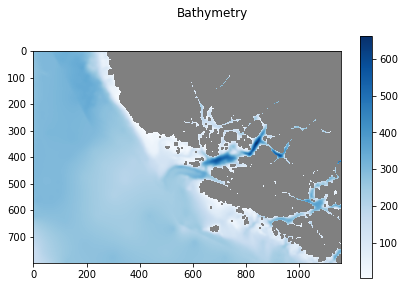

In [8]:
from netCDF4 import Dataset
nc = Dataset(source_url)

H_m = np.ma.array(nc["h"][1:-1,1:-1], mask=(1-nc["mask_rho"][1:-1,1:-1]))

fig, ax = plt.subplots()
fig.suptitle("Bathymetry")

cmap = plt.cm.Blues
cmap.set_bad("grey", alpha = 1.0)
im = ax.imshow(H_m, cmap=cmap)

plt.colorbar(im, ax=ax)
plt.tight_layout()

In [9]:
datetime.datetime.utcfromtimestamp(nc["ocean_time"][10]).strftime('%Y-%m-%d %H:%M:%S')

'2041-11-01 11:00:00'

## Generating GPUOcean Simulation from Input

In [10]:
dimY, dimX = ds.h.data.shape

In [11]:
x0, x1, y0, y1 = 687, dimX-25, 120, dimY-330

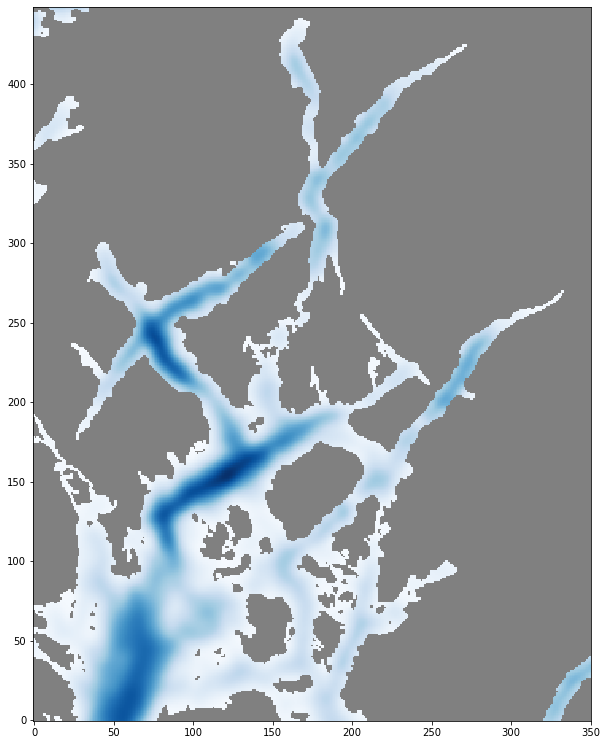

In [12]:
fig, ax = plt.subplots(figsize=(10,20))
ax.imshow(np.flip(np.ma.array(nc["h"][y0:y1, x0:x1], mask = 1-nc["mask_rho"][y0:y1,x0:x1]), axis=0).T, interpolation="none", cmap="Blues", origin="lower")

In [13]:
data_args = {}

In [14]:
nc.variables.keys()

dict_keys(['ocean_time', 'Vtransform', 'Vstretching', 'theta_s', 'theta_b', 'Tcline', 'hc', 's_rho', 's_w', 'Cs_r', 'Cs_w', 'h', 'mask_rho', 'mask_u', 'mask_v', 'angle', 'pm', 'pn', 'lon_rho', 'lat_rho', 'lon_u', 'lat_u', 'lon_v', 'lat_v', 'aice', 'hice', 'snow_thick', 'uice', 'vice', 'zeta', 'ubar', 'vbar', 'Uwind', 'Vwind', 'swrad', 'u', 'v', 'temp', 'salt', 'AKt', 'AKs'])

In [15]:
nx = (x1-x0)-4
ny = (y1-y0)-4

NX = nx+4
NY = ny+4

dx = 160.0
dy = 160.0

Check Mixed-Layer Depth

In [16]:
t=10

In [17]:
mld = NetCDFInitialization.MLD(source_url, 1023, min_mld=1.5, max_mld=15, x0=x0, x1=x1, y0=y0, y1=y1, t=t)
backup_mld = copy.deepcopy(mld)

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Blues"))
  


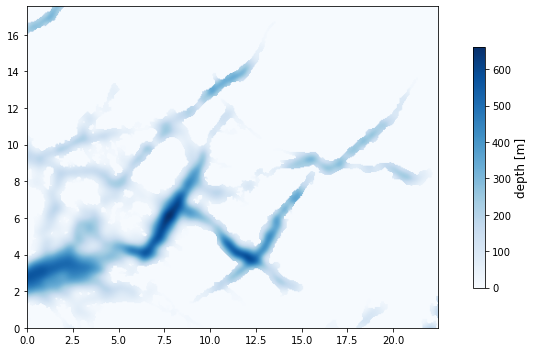

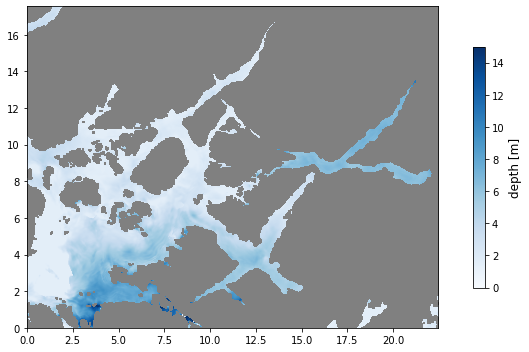

In [18]:
cmap = plt.cm.Blues
cmap.set_bad("grey", alpha = 1.0)

domain_extent = [0, mld.shape[1]*50/1000, 0, mld.shape[0]*50/1000]

with plt.rc_context({'lines.color':'black', 
                        'text.color':'black', 
                        'axes.labelcolor':'black', 
                        'xtick.color':'black',
                        'ytick.color':'black'}):
    fig, ax = plt.subplots(figsize=(10,5))
    im = ax.imshow(np.ma.array(nc["h"][y0:y1,x0:x1], mask=(nc["h"][y0:y1,x0:x1]==0)), 
                   vmin=0,
                   cmap=cmap, extent=domain_extent)
    cb = plt.colorbar(im, ax=ax, shrink=0.75)
    cb.set_label(label="depth [m]", size=12)
    plt.tight_layout()
    # plt.savefig("figs/Oslofjord-bathymetry.pdf", dpi=200)


    fig, ax = plt.subplots(figsize=(10,5))
    im = ax.imshow(mld, 
                    vmin=0, vmax=15,
                    cmap=cmap, extent=domain_extent)
    cb = plt.colorbar(im, ax=ax, shrink=0.75)
    cb.set_label(label="depth [m]", size=12)
    plt.tight_layout()
    # plt.savefig("figs/Oslofjord-mld.pdf", dpi=200)


Check densities

In [19]:
y_cut = 75

2041-11-01 11:00:00


/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))


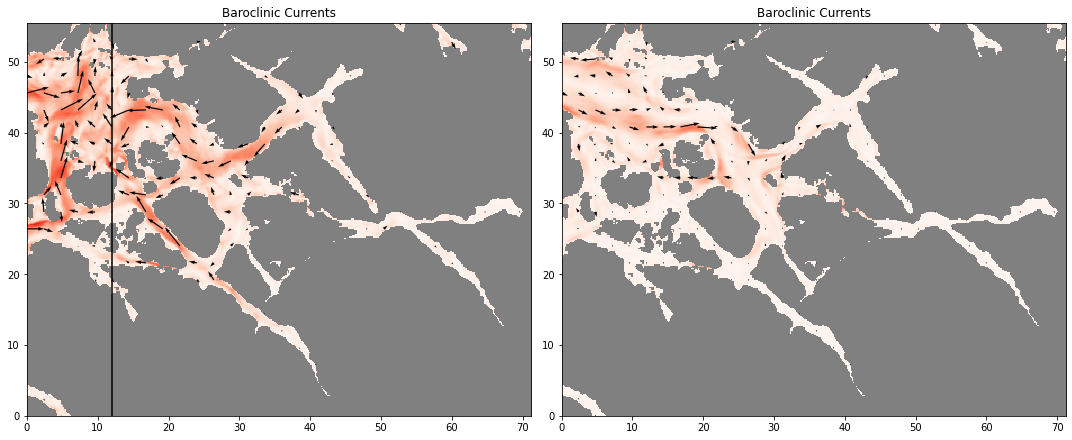

In [20]:
H_m = nc["h"][y0:y1,x0:x1]

u = 0.5*(nc["u"][t,:,y0:y1,x0:x1]+nc["u"][t,:,y0:y1,x0+1:x1+1])
v = 0.5*(nc["v"][t,:,y0:y1,x0:x1]+nc["v"][t,:,y0+1:y1+1,x0:x1])

integrator = NetCDFInitialization.MLD_integrator(source_url, mld, x0=x0, x1=x1, y0=y0, y1=y1)
hu = np.ma.array(np.sum(integrator * u, axis=0), mask=1-nc["mask_rho"][y0:y1,x0:x1])
hv = np.ma.array(np.sum(integrator * v, axis=0), mask=1-nc["mask_rho"][y0:y1,x0:x1])

u = hu/mld
v = hv/mld
velocity = np.sqrt(u*u + v*v)

domain_extent = [0, nx*dx/1000, 0, ny*dy/1000]

frequency_x = 15
frequency_y = 15
x = np.arange(0, velocity.shape[1], frequency_x)*dx/1000
y = np.arange(0, velocity.shape[0], frequency_y)*dy/1000
qu = u[::frequency_y, ::frequency_x]
qv = v[::frequency_y, ::frequency_x]

# ---------------------------

bt_u = 0.5*(nc["ubar"][t,y0:y1,x0:x1]+nc["ubar"][t,y0:y1,x0+1:x1+1])
bt_v = 0.5*(nc["vbar"][t,y0:y1,x0:x1]+nc["vbar"][t,y0+1:y1+1,x0:x1])

bt_velocity = np.sqrt(bt_u*bt_u + bt_v*bt_v)

bt_qu = bt_u[::frequency_y, ::frequency_x]
bt_qv = bt_v[::frequency_y, ::frequency_x]


# ----------------------------

with plt.rc_context({'lines.color':'black', 
                        'text.color':'black', 
                        'axes.labelcolor':'black', 
                        'xtick.color':'black',
                        'ytick.color':'black'}):
    fig, axs = plt.subplots(1,2,figsize=(15,10))

    # ax.tick_params(colors='black')
    axs[0].xaxis.label.set_color('black')

    velo_cmap = plt.cm.Reds
    velo_cmap.set_bad("grey", alpha = 1.0)

    im = axs[0].imshow(velocity, interpolation="none", origin='lower', 
                        cmap=velo_cmap,
                        vmin=0, vmax=0.5,
                        extent=domain_extent)
    axs[0].quiver(x,y,qu,qv, scale=5)

    cb = plt.colorbar(im, ax=ax, shrink=1)
    cb.set_label(label="velocity $\left[ \\frac{m}{s} \\right]$", size=12)
    
    axs[0].axvline(x=y_cut*dx/1000, c="black")
    
    axs[0].set_title("Baroclinic Currents")
    
    # -------------------------------------
    
    im = axs[1].imshow(bt_velocity, interpolation="none", origin='lower', 
                        cmap=velo_cmap,
                        vmin=0, vmax=0.5,
                        extent=domain_extent)
    axs[1].quiver(x,y,bt_qu,bt_qv, scale=5)

    cb = plt.colorbar(im, ax=ax, shrink=1)
    cb.set_label(label="velocity $\left[ \\frac{m}{s} \\right]$", size=12)
    
    axs[1].set_title("Baroclinic Currents")


    plt.tight_layout()

    # plt.savefig("figs/PotDensLine.pdf", dpi=200)

print(str(datetime.datetime.utcfromtimestamp(nc["ocean_time"][t]).strftime('%Y-%m-%d %H:%M:%S')))


In [21]:
s_pot_densities = NetCDFInitialization.potentialDensities(source_url, t=t, x0=x0, x1=x1, y0=y0, y1=y1)

s_nc = Dataset(source_url)
s_hs   = s_nc["h"][y0:y1,x0:x1]
s_rhos = s_nc["Cs_r"][:]

depth_show_meters = 50 # upper layer thickness for plotting in meters

depth_show_resolution = 4 # discretisation levels per meter

s_pot_densities_show = np.ma.array(np.zeros((s_pot_densities.shape[1],depth_show_meters*depth_show_resolution)))
s_pot_densities_show[:,0] =  s_pot_densities[-1][:,y_cut]
for depth_level in range(1,depth_show_resolution*depth_show_meters):
    depth = depth_level/depth_show_resolution

    integrator_low = NetCDFInitialization.MLD_integrator(source_url, np.ma.array(depth*np.ones_like(H_m),mask=False), t=t, x0=x0, x1=x1, y0=y0, y1=y1)
    dens_low = np.sum(integrator_low * s_pot_densities, axis=0)
    if depth_level == 1:
        dens_up = 0.0
        s_pot_densities_show[:,depth_level] =  (dens_low - dens_up)[:,y_cut]*depth_show_resolution
        mask_next_level = copy.copy(s_pot_densities_show[:,depth_level]<1000)
    else:
        integrator_up = NetCDFInitialization.MLD_integrator(source_url, np.ma.array((depth-1/depth_show_resolution)*np.ones_like(H_m),mask=False), t=t, x0=x0, x1=x1, y0=y0, y1=y1)
        dens_up  = np.sum(integrator_up * s_pot_densities, axis=0)
        s_pot_densities_show[:,depth_level] =  (dens_low - dens_up)[:,y_cut]*depth_show_resolution
        s_pot_densities_show[:,depth_level].mask = copy.copy(mask_next_level)
        if depth > 5:
            mask_next_level = np.all((integrator_low[1:,:,y_cut] == integrator_up[1:,:,y_cut]), axis=0)

In [22]:
import matplotlib.lines as mlines

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("YlOrRd_r"))
  after removing the cwd from sys.path.


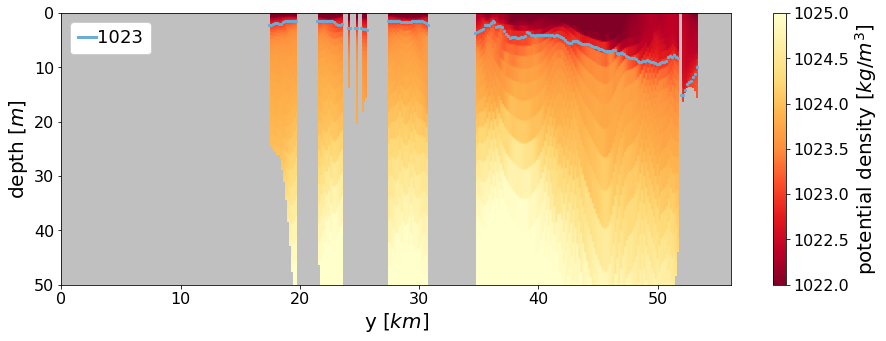

In [23]:
fig, ax = plt.subplots(1,1,figsize=(15,5))

cmap_dens = plt.cm.YlOrRd_r
cmap_dens.set_bad(alpha=0.25)

extent = [0, s_pot_densities_show.shape[0]*160/1000, depth_show_meters, 0]

im = ax.imshow(s_pot_densities_show.T, 
                origin="upper", cmap=cmap_dens, 
                aspect='auto', extent=extent, 
                vmin=1022, vmax=1025)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel("depth [$m$]", fontsize=20)
ax.set_xlabel("y [$km$]", fontsize=20)

cb = plt.colorbar(im, pad=0.05)
cb.set_label(label="potential density [$kg/m^3$]", size=20)
cb.ax.tick_params(labelsize=16)

ax.scatter(np.arange(s_pot_densities.shape[1])*160/1000, mld[:,y_cut], s=5, color=plt.cm.Blues(0.5))

legend_handle = mlines.Line2D([], [], c=plt.cm.Blues(0.5), lw=3, label="1023")
plt.legend(handles=[legend_handle], handlelength=1, loc=2, 
        handletextpad=0.1, 
        facecolor="white", framealpha=1,
        labelcolor="black", fontsize=18)

plt.savefig("BoknafjordenMLD.pdf", bbox_inches="tight")

Note that the stratification is less pronounced than in the Oslofjord, but we still get a usable and shallow MLD

## GPU Ocean Inputs

In [24]:
t_start = t
t_stop =  t_start + 6

T = (t_stop-t_start)*3600  #Input
timestep_indices = [list(np.arange(t_start, t_stop+1))]

In [25]:
barotropic_data_args, baroclinic_data_args = NetCDFInitialization.getCombinedInitialConditions(source_url, x0, x1, y0, y1, 1023, timestep_indices=timestep_indices, norkyst_data=False, land_value=5.0, download_data=False)

### Drifters

In [26]:
windage = 0.0

Barotropic drift

In [27]:
from gpuocean.SWEsimulators import CDKLM16

In [28]:
barotropic_sim = CDKLM16.CDKLM16(barotropic_gpu_ctx, **NetCDFInitialization.removeMetadata(barotropic_data_args), dt=0.0, write_netcdf=True)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [29]:
from gpuocean.utils import Observation
from gpuocean.drifters import GPUDrifterCollection
from gpuocean.dataassimilation import DataAssimilationUtils as dautils

In [30]:
initx = [12500,  7500, 12500,  1250,  7500]
inity = [40000, 42500, 45000, 43750, 45000]

num_drifters = len(initx)

In [31]:
observation_type = dautils.ObservationType.UnderlyingFlow 
    
observation_args = {'observation_type': observation_type,
                'nx': barotropic_sim.nx, 'ny': barotropic_sim.ny,
                'domain_size_x': barotropic_sim.nx*barotropic_sim.dx,
                'domain_size_y': barotropic_sim.ny*barotropic_sim.dy,
                'land_mask': barotropic_sim.getLandMask()
                }

bt_trajectories = Observation.Observation(**observation_args)

In [32]:
bt_drifters = GPUDrifterCollection.GPUDrifterCollection(barotropic_gpu_ctx, num_drifters,
                                                    boundaryConditions = barotropic_sim.boundary_conditions,
                                                    domain_size_x = bt_trajectories.domain_size_x,
                                                    domain_size_y = bt_trajectories.domain_size_y,
                                                    gpu_stream = barotropic_sim.gpu_stream,
                                                    wind = barotropic_data_args["wind"],
                                                    wind_drift_factor=windage
                                                    )

drifter_pos_init = np.array([initx, inity]).T
bt_drifters.setDrifterPositions(drifter_pos_init)



In [33]:
barotropic_sim.attachDrifters(bt_drifters)
bt_trajectories.add_observation_from_sim(barotropic_sim)

In [34]:
while barotropic_sim.t < T:
    barotropic_sim.step(300)
    bt_trajectories.add_observation_from_sim(barotropic_sim)

In [35]:
import animation_utils

In [36]:
# animation_utils.ncAnimation(barotropic_sim.sim_writer.output_file_name, "gpuocean", comment="Barotropic")

Baroclinic drift

In [37]:
baroclinic_data_args["wind_stress_factor"] = 0.5
baroclinic_data_args["r"] = 0.0015

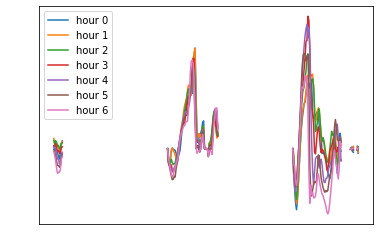

In [38]:
for hour in range(7):
    plt.plot(baroclinic_data_args["boundary_conditions_data"].west.hu[hour]/baroclinic_data_args["boundary_conditions_data"].west.h[hour], label="hour "+str(hour))
plt.legend(labelcolor="black")

In [39]:
baroclinic_sim = CDKLM16.CDKLM16(baroclinic_gpu_ctx, **NetCDFInitialization.removeMetadata(baroclinic_data_args), dt=0.0, write_netcdf=True)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [40]:
bc_trajectories = Observation.Observation(**observation_args)

In [41]:
bc_drifters = GPUDrifterCollection.GPUDrifterCollection(baroclinic_gpu_ctx, num_drifters,
                                                    boundaryConditions = baroclinic_sim.boundary_conditions,
                                                    domain_size_x = bc_trajectories.domain_size_x,
                                                    domain_size_y = bc_trajectories.domain_size_y,
                                                    gpu_stream = baroclinic_sim.gpu_stream,
                                                    wind = baroclinic_data_args["wind"],
                                                    wind_drift_factor=windage
                                                    )

bc_drifters.setDrifterPositions(drifter_pos_init)

In [42]:
baroclinic_sim.attachDrifters(bc_drifters)
bc_trajectories.add_observation_from_sim(baroclinic_sim)

In [43]:
while baroclinic_sim.t < T:
    baroclinic_sim.step(300)
    bc_trajectories.add_observation_from_sim(baroclinic_sim)

In [44]:
# animation_utils.ncAnimation(baroclinic_sim.sim_writer.output_file_name, "gpuocean-reduced_grav", comment="Baroclinic")

Combined sim

In [45]:
from gpuocean.SWEsimulators import CombinedCDKLM16

In [46]:
from importlib import reload
reload(CombinedCDKLM16)

<module 'gpuocean.SWEsimulators.CombinedCDKLM16' from '/home/florianb/havvarsel/gpuocean/src/gpuocean/SWEsimulators/CombinedCDKLM16.py'>

In [47]:
barotropic_sim = CDKLM16.CDKLM16(barotropic_gpu_ctx, **NetCDFInitialization.removeMetadata(barotropic_data_args), dt=0.0)
baroclinic_sim = CDKLM16.CDKLM16(baroclinic_gpu_ctx, **NetCDFInitialization.removeMetadata(baroclinic_data_args), dt=0.0)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


Closing file /home/florianb/havvarsel/reduced-gravity-ocean-model/notebooks/OtherFjords/netcdf_2023_03_22/CDKLM16_2023_03_22-13_53_32.nc ...
Closing file /home/florianb/havvarsel/reduced-gravity-ocean-model/notebooks/OtherFjords/netcdf_2023_03_22/CDKLM16_2023_03_22-13_53_48.nc ...


In [48]:
combined_sim = CombinedCDKLM16.CombinedCDKLM16(barotropic_sim=barotropic_sim, baroclinic_sim=baroclinic_sim)

In [49]:
combi_trajectories = Observation.Observation(**observation_args)

In [50]:
combi_drifters = GPUDrifterCollection.GPUDrifterCollection(barotropic_gpu_ctx, num_drifters,
                                                    boundaryConditions = combined_sim.boundary_conditions,
                                                    domain_size_x = combi_trajectories.domain_size_x,
                                                    domain_size_y = combi_trajectories.domain_size_y,
                                                    gpu_stream = combined_sim.gpu_stream,
                                                    wind = barotropic_data_args["wind"],
                                                    wind_drift_factor=windage/2
                                                    )


In [51]:
combi_drifters.setDrifterPositions(drifter_pos_init)

In [52]:
combined_sim.attachDrifters(combi_drifters)
combi_trajectories.add_observation_from_sim(combined_sim)

In [53]:
combined_sim.combinedStep(T, trajectory_dt=360, trajectories=combi_trajectories)

(21600.0, 21600.0)

### Plots

In [75]:
def plot_trajectory(trajectories0, trajectories1, trajectories2, trajectories3=None, zoom=[0, None, 0, None]):
    with plt.rc_context({'lines.color':'black', 
                            'text.color':'black', 
                            'axes.labelcolor':'black', 
                            'xtick.color':'black',
                            'ytick.color':'black'}):
        fig, ax = plt.subplots(1,1, figsize=(10,10))
        ax.tick_params(axis='both', which='major', labelsize=28)

        zoom_x0, zoom_x1, zoom_y0, zoom_y1 = zoom

        if zoom_x1 is None:
            dom_x1 = nx
        else:
            dom_x1 = zoom_x1
        if zoom_y1 is None:
            dom_y1 = ny
        else:
            dom_y1 = zoom_y1
        domain_extent = [zoom_x0*dx/1000, dom_x1*dx/1000, zoom_y0*dy/1000, dom_y1*dy/1000]

        bg_cmap = copy.deepcopy(plt.cm.Blues)
        bg_cmap.set_bad("grey", alpha = 1.0)
        
        ax.imshow(np.ma.array(nc["mask_rho"][y0:y1, x0:x1][zoom_y0:zoom_y1, zoom_x0:zoom_x1], mask=(1-nc["mask_rho"][y0:y1, x0:x1][zoom_y0:zoom_y1, zoom_x0:zoom_x1])), 
                  interpolation="none", origin='lower', cmap=bg_cmap, extent=domain_extent)

        for d in range(len(initx)):
            path = trajectories0.get_drifter_path(d, 0, T, in_km = True)[0]
            start_pos = path[0,:]
            circ_start = matplotlib.patches.Circle((start_pos[0], start_pos[1]), 
                                                    0.1, color = 'black', fill=True, zorder=10)
            ax.add_patch(circ_start)

            colors = ["C0", "C1", "C2", "C3"]            
            trajectory_list = [trajectories0, trajectories1, trajectories2]
            if trajectories3 is not None:
                trajectory_list.append(trajectories3)
            for p_idx, path in enumerate([t.get_drifter_path(d, 0, T, in_km = True)[0] for t in trajectory_list]):
                ax.plot(path[:,0], path[:,1], color=colors[p_idx], ls="-", zorder=5, alpha=1.0, lw=2.0)
                end_pos = path[-1,:]
                ax.scatter(end_pos[0], end_pos[1], marker='x', color='black', s=50, linewidths=1, alpha=1.0, zorder=6)

        plt.tight_layout()

        legend_handles = [ mlines.Line2D([], [], c="C0", lw=3, label="barotropic"),
                            mlines.Line2D([], [], c="C1", lw=3, label="baroclinic"),
                            mlines.Line2D([], [], c="C2", lw=3, label="combined")]
        if trajectories3 is not None:
            legend_handles.append( mlines.Line2D([], [], c="C3", lw=3, label="OpenDrift") )
        plt.legend(handles=legend_handles, handlelength=1,
        facecolor="white", framealpha=1,
        labelcolor="black", fontsize=18)

        plt.savefig("BoknafjordenDrifts.pdf", bbox_inches="tight")

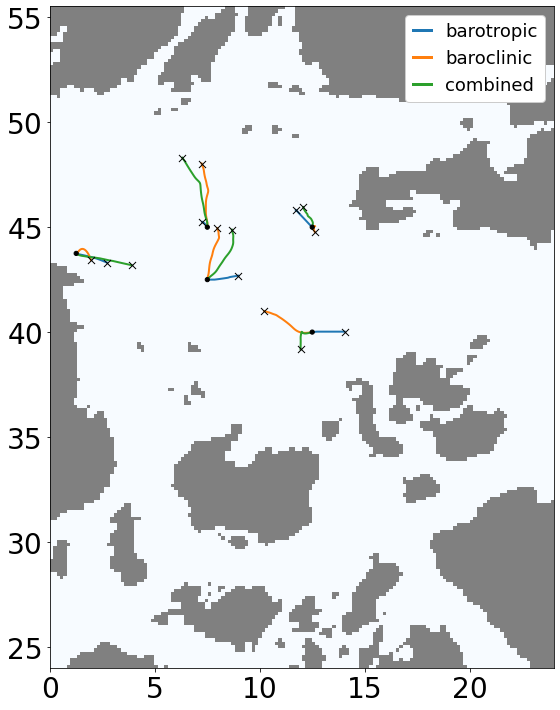

In [76]:
plot_trajectory(bt_trajectories, bc_trajectories, combi_trajectories, zoom=[0,150,150,None])

## OpenDrift

In [58]:
from opendrift.readers import reader_netCDF_CF_generic, reader_ROMS_native
from opendrift.models.oceandrift import OceanDrift
from datetime import datetime, timedelta

import xarray as xr

In [59]:
reader_boknafjorden = reader_ROMS_native.Reader(source_url)
reader_boknafjorden.start_time

No proj string or projection could be derived, using 'fakeproj'. This assumes that the variables are structured and gridded approximately equidistantly on the surface (i.e. in meters). This must be guaranteed by the user. You can get rid of this warning by suppling a valid projection to the reader.


datetime.datetime(2019, 11, 1, 1, 0)

In [60]:
# Checking how to map (x,y) to/from (lon, lat)

#eta_rho: 801 xi_rho: 1161
lon0 = ds.lon_rho.isel(eta_rho=0, xi_rho=0).data, 
lat0 = ds.lat_rho.isel(eta_rho=0, xi_rho=0).data
print("lonlat(0, 0): ", (lon0, lat0))
print("\tgives (x, y): ", reader_boknafjorden.lonlat2xy(lon0, lat0))

lonend = ds.lon_rho.isel(eta_rho=801-1, xi_rho=1161-1).data
latend = ds.lat_rho.isel(eta_rho=801-1, xi_rho=1161-1).data
print("lonlat(-1, -1): ", (lonend, latend))
print("\tgives (x, y): ", reader_boknafjorden.lonlat2xy(lonend, latend))


lon0u = ds.lon_u.isel(eta_u=0, xi_u=0).data, 
lat0u = ds.lat_u.isel(eta_u=0, xi_u=0).data
print("lonlatu(0, 0): ", (lon0, lat0))
print("\tgives (x, y): ", reader_boknafjorden.lonlat2xy(lon0, lat0))

lonlat(0, 0):  ((array(5.73786262),), array(58.00917678))
	gives (x, y):  (array([0.]), array([0.]))
lonlat(-1, -1):  (array(5.11597068), array(59.99781934))
	gives (x, y):  (array(1160.), array(800.))
lonlatu(0, 0):  ((array(5.73786262),), array(58.00917678))
	gives (x, y):  (array([0.]), array([0.]))


Based on the dimensions of eta_* and xi_*, it seems that eta_rho and xi_rho is from boundary to boundary. 

In [61]:
# Translate initx, inity to initlon, initlat
initx = np.array([12500,  7500, 12500,  1250,  7500])
inity = np.array([40000, 42500, 45000, 43750, 45000])

init_local_index_x = initx/160
init_local_index_y = inity/160

init_global_index_x = init_local_index_x + x0
init_global_index_y = init_local_index_y + y0

print(init_local_index_x)
print(init_global_index_x)

init_lon, init_lat = reader_boknafjorden.xy2lonlat(init_global_index_x, init_global_index_y)
print("init_lon: ", init_lon)
print("init_lat: ", init_lat)

[78.125  46.875  78.125   7.8125 46.875 ]
[765.125  733.875  765.125  694.8125 733.875 ]
init_lon:  [5.73497767 5.65788755 5.65634236 5.59118576 5.61859841]
init_lat:  [59.22190485 59.19130585 59.24129537 59.14575134 59.20097932]


In [62]:
o = OceanDrift(loglevel=20)

#o.add_reader([reader_barents, reader_wind])
o.add_reader(reader_boknafjorden)


13:54:44 INFO    opendrift.models.basemodel: OpenDriftSimulation initialised (version 1.8.5)


In [63]:
o.seed_elements(lat=init_lat, lon=init_lon, time=reader_boknafjorden.start_time+ timedelta(hours=10), 
                wind_drift_factor=np.zeros_like(init_lat))


In [64]:
o.run(duration = timedelta(hours=6), time_step=600, time_step_output=600)


13:54:45 INFO    opendrift.models.basemodel: Fallback values will be used for the following variables which have no readers: 
13:54:45 INFO    opendrift.models.basemodel: 	upward_sea_water_velocity: 0.000000
13:54:45 INFO    opendrift.models.basemodel: 	sea_surface_wave_significant_height: 0.000000
13:54:45 INFO    opendrift.models.basemodel: 	sea_surface_wave_stokes_drift_x_velocity: 0.000000
13:54:45 INFO    opendrift.models.basemodel: 	sea_surface_wave_stokes_drift_y_velocity: 0.000000
13:54:45 INFO    opendrift.models.basemodel: 	sea_surface_wave_period_at_variance_spectral_density_maximum: 0.000000
13:54:45 INFO    opendrift.models.basemodel: 	sea_surface_wave_mean_period_from_variance_spectral_density_second_frequency_moment: 0.000000
13:54:45 INFO    opendrift.models.basemodel: 	surface_downward_x_stress: 0.000000
13:54:45 INFO    opendrift.models.basemodel: 	surface_downward_y_stress: 0.000000
13:54:45 INFO    opendrift.models.basemodel: 	turbulent_kinetic_energy: 0.000000
13:5

In [56]:
o_trajectories = Observation.Observation(domain_size_x=nx*dx, domain_size_y=ny*dy, nx=x1-x0, ny=y1-y0, land_mask=barotropic_sim.getLandMask())

In [66]:
t = o.get_time_array()[1]
for i in range(len(t)):
    t[i] = t[i].total_seconds()
t = np.array(t)

In [67]:
lon, lat = o.get_lonlats()
x,y = reader_boknafjorden.lonlat2xy(lon,lat)

In [68]:
X = (x-x0)*160
Y = (y-y0)*160

In [69]:
o_trajectories = Observation.Observation(domain_size_x=dx*nx, domain_size_y=ny*dy,
                        nx=x1-x0, ny=y1-y0, land_mask=barotropic_sim.getLandMask())

In [70]:
o_trajectories.add_observations_from_arrays(t, X, Y)

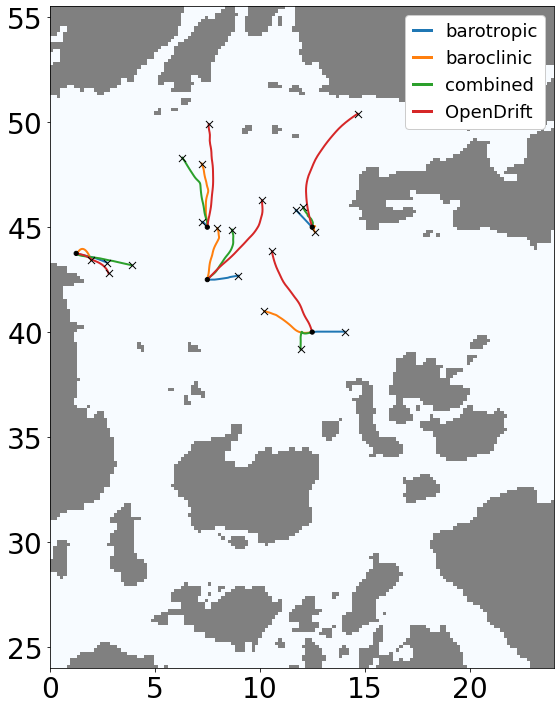

In [77]:
plot_trajectory(bt_trajectories, bc_trajectories, combi_trajectories, o_trajectories, zoom=[0,150,150,None])